<a href="https://colab.research.google.com/github/archyyu/GPT-from-MLP-to-RNN-to-Transformer/blob/main/GPT_by_Deep_RNN_version_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

# Set random seed for reproducibility
torch.manual_seed(42)

In [2]:
# Data I/O

url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
#url = "https://raw.githubusercontent.com/archyyu/publicResource/main/google.dev.en"
#url = "https://raw.githubusercontent.com/torvalds/linux/master/mm/madvise.c"
response = requests.get(url)
data = response.text

n = int(0.9*len(data))
taining_data = data[:n]
val_data = data[n:]

chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print(f'data has {data_size} characters, {vocab_size} unique.')

char_to_ix = {ch: i for i, ch in enumerate(chars)}
ix_to_char = {i: ch for i, ch in enumerate(chars)}

data has 1115394 characters, 65 unique.


In [29]:
# Hyperparameters
hidden_size = 100
embedding_dim = 20
seq_length = 25
learning_rate = 1e-1
batch_size = 20
deep_num = 3
dropout_prob = 0.1
eval_iters = 10


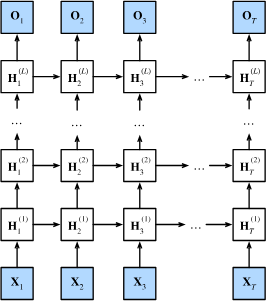

as illustrated by the above graph.
we could define the layers of the rnn as deep_num
and every hidden state is decided by the pre step hidden state and the lower layers hidden state.

let us implement this structure.

from what I understand, If the RNN is deep, let say 3 layers, then the performance of the model should be better?

but the result is a little disappointing. dont know why

So I update the deepRNN again.

Let see the result

In [30]:
# We should change the VanillaRNN a little bit, so could be used in deep RNN.
class SimpleRNN(nn.Module):
  def __init__(self, hidden_size):
    super(SimpleRNN, self).__init__()
    self.i2h = nn.Linear(hidden_size, hidden_size, bias=False)
    self.h2h = nn.Linear(hidden_size, hidden_size, bias=False)
    self.ob = nn.Parameter(torch.zeros(1, hidden_size))
    # self.layer_norm = nn.LayerNorm(hidden_size)

  def forward(self, pre_h_list):
    h_list = []
    for i in range(pre_h_list.size(1)):
      if i == 0:
        h = torch.tanh(self.i2h(pre_h_list[:, i, :]) + self.ob)
      else:
        h = torch.tanh(self.i2h(pre_h_list[:, i, :]) + self.h2h(h) + self.ob)
      h_list.append(h)

    return torch.stack(h_list, dim=1)


class DeepRNN(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_size, deep_num):
    super(DeepRNN, self).__init__()
    self.deep_num = deep_num
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.e2h = nn.Linear(embedding_dim, hidden_size, bias=False)
    self.rnn_list = nn.ModuleList([SimpleRNN(hidden_size) for _ in range(deep_num)])
    self.h2o = nn.Linear(hidden_size, vocab_size, bias=False)
    self.ob = nn.Parameter(torch.zeros(1, vocab_size))

  def forward(self, x):
    x = self.embedding(x)
    B,T,C = x.shape
    # print(x.shape)
    h = self.e2h(x)
    # h = x
    # print(h.shape)
    for i in range(self.deep_num):
      h = self.rnn_list[i](h)

    # print(h.shape)
    y = self.h2o(h) + self.ob
    # print(y.shape)
    return y

# Loss function
criterion = nn.CrossEntropyLoss()

# Model initialization
model = DeepRNN(vocab_size, embedding_dim, hidden_size, deep_num)
optimizer = optim.Adagrad(model.parameters(), lr=learning_rate)

I updated the VanillaRNN a little, since We dont need the output of the intermediate node in Deep RNN, so we could remove the self.h2o linear layer. and add an final linear layer in the upper layer, by doing so, we could significantly reduce the amount of the parameters in the nn.

In [31]:
def get_batch():
  batch_inputs = []
  batch_targets = []

  # Generate examples for the current minibatch
  # print(torch.randint(10,[2]))
  start_idx = torch.randint(len(data) - batch_size - seq_length - 2,[1]).item()
  for i in range(batch_size):
    p = start_idx + i
    inputs = torch.tensor([char_to_ix[ch] for ch in data[p:p + seq_length]], dtype=torch.long).view(1, -1)
    targets = torch.tensor([char_to_ix[ch] for ch in data[p + 1:p + seq_length + 1]], dtype=torch.long).view(-1)

    batch_inputs.append(inputs)
    batch_targets.append(targets)

  # Convert lists to tensors
  minibatch_inputs = torch.cat(batch_inputs, dim=0)
  minibatch_targets = torch.stack(batch_targets)
  return minibatch_inputs, minibatch_targets


@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [32]:
stopi = []
lossi = []

In [38]:
# Training loop
num_iterations = 2 * 1000000
for iteration in range(num_iterations):

  inputs, targets = get_batch()

  predict_char = model(inputs)

  optimizer.zero_grad(set_to_none=True)
  B,T = targets.shape

  loss = criterion(predict_char.view(B*T, -1), targets.view(B*T))

  loss.backward()

  # break

  for param in model.parameters():
    if param.grad is not None:
      param.grad.data.clamp_(-5, 5)

  optimizer.step()
  if iteration % 1000 == 0:
    print(f'Iteration {iteration}, Loss: {loss.item()}')
    stopi.append(iteration)
    lossi.append(loss.item())



Iteration 0, Loss: 1.4726958274841309
Iteration 1000, Loss: 2.138493537902832
Iteration 2000, Loss: 2.3313748836517334
Iteration 3000, Loss: 1.933477520942688
Iteration 4000, Loss: 1.377227544784546
Iteration 5000, Loss: 2.1454758644104004
Iteration 6000, Loss: 2.052341938018799
Iteration 7000, Loss: 2.052809953689575
Iteration 8000, Loss: 1.4336575269699097
Iteration 9000, Loss: 1.908461093902588


KeyboardInterrupt: 

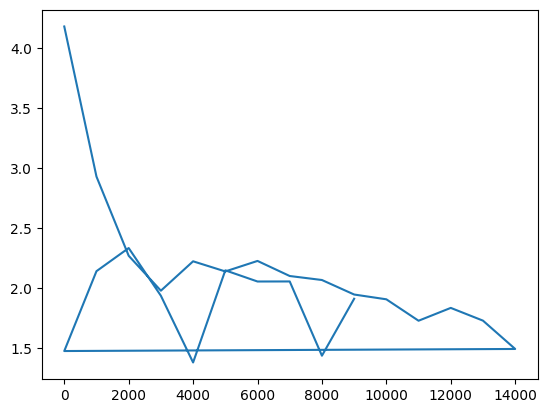

In [39]:
plt.plot(stopi, lossi)

In [41]:
# Sample from the model
x = torch.tensor(char_to_ix[data[0]], dtype=torch.long).view(1, 1)
ixes = []
ixes.append(ix_to_char[x[0][0].item()])

n = 2000

for _ in range(n):
  inputs = torch.tensor([char_to_ix[ch] for ch in ixes[-seq_length * 3:]], dtype=torch.long).view(1, -1)
  outputs = model(inputs)
  outputs = outputs[:,-1,:]
  p = nn.functional.softmax(outputs, dim=-1).detach().numpy().ravel()
  ix = np.random.choice(range(vocab_size), p=p)
  y = torch.tensor(ix, dtype=torch.long).view(1, 1)

  ixes.append(ix_to_char[y[0][0].item()])

print(''.join(ixes))

For a mefea?

PAURENCENSE OF , OLNNA:
I karted to fird,
To he stidancue.

Vurst I'll where, alace not thee, I son, grayess, merper.

ANGER:
Thy day I good it
Tambear awmer.

ROMEONDESLELO:
Affiwost be's a good fiter?

ALARTIO:
Thy he neoraa, udats repet.

GENEG:
'Ty graciert;
And I at of he gracion I is bi'dh that marne hoer and of you, ene foehord;
The hear his choem a mis
Res our of than father;
And madmife, soNtorves, when in dear they done, what upon keen hear and one a all kent;
Which for this ene
That crown:
If the me, iccome threat yier. Shou spour be al in minsht,
Wibelordian me't weay, the ther,
For is goo!

First
The somes ictent bow us look of fatutor whire,
Risen dadot you bet awuaters from thinhwseguous tean that yut in nemepibuoought,
Arifore dral mewi!
Yive
And no suay he heard wuth sear made:
Nh-CIEY:
O Gwrom awe's the poor meay at lodies brother the speer is his the souse my diress
The grass I world in from and iffel.

Like, to the care mere it for ploody
And not, woul